#  GOP Debate Twitter Sentiment Analysis

the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

In [49]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt


data = pd.read_csv('./Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]
data.head(5)

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


## texts to sequences

I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain. Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [47]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].shape)
print(data[ data['sentiment'] == 'Negative'].shape)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

(2236, 2)
(8493, 2)


the training data is very unbalanced (pos: 2236, neg: 8493), the network could perform poorly.

## split data set

In [3]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(7510, 28) (7510, 2)
(3219, 28) (3219, 2)


## build model

In [4]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
#model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
#model.add(TimeDistributed(Dense(2,activation='softmax')))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())



W0812 15:05:57.929793 4526613952 deprecation_wrapper.py:119] From /Users/sunshuhan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 15:05:57.957010 4526613952 deprecation_wrapper.py:119] From /Users/sunshuhan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 15:05:57.958868 4526613952 deprecation_wrapper.py:119] From /Users/sunshuhan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 15:05:57.973733 4526613952 deprecation_wrapper.py:119] From /Users/sunshuhan/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


## report hyperparams, arch ,...

### hyperparameters
- max_fatures = 2000
- pembed_dim = 128
- lstm_out = 196
- droupout_x = 0.2
- recurrent_dropout=0.2
- batch_size = 64
- activation='softmax'
- loss = 'categorical_crossentropy'
- optimizer='adam'

> values are somehow intuitive, can be and must be played with in order to achieve good results. 

> activation='softmax': The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.
w
### layers
- Embedding(max_fatures, embed_dim,input_length = X.shape[1]) 
work with sparse categorical variables. Map word to a vector of real numbers

Arguments:
input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
output_dim: int >= 0. Dimension of the dense embedding.

- SpatialDropout1D(0.4)
Spatial 1D version of Dropout.
 it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout1D will help promote independence between feature maps and should be used instead.

Arguments:
rate: Fraction of the input units to drop.

- LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)
Long Short-Term Memory layer

Arguments:
units: Positive integer, dimensionality of the output space.
dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

- Dense(2,activation='softmax')  #putout
Core Layers, regular densely-connected NN layer.
Dense implements the operation: output = activation(dot(input, kernel) + bias)

Arguments:
units: Positive integer, dimensionality of the output space.
activation: Activation function to use (see activations). If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).

## train mode

In [30]:
batch_size = 64
history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 1, validation_data=(X_test, Y_test))

Train on 7510 samples, validate on 1219 samples
Epoch 1/10
 - 20s - loss: 0.1301 - acc: 0.9462 - val_loss: 0.6813 - val_acc: 0.8187
Epoch 2/10
 - 21s - loss: 0.1280 - acc: 0.9462 - val_loss: 0.6025 - val_acc: 0.8195
Epoch 3/10
 - 21s - loss: 0.1196 - acc: 0.9507 - val_loss: 0.7797 - val_acc: 0.8171
Epoch 4/10
 - 21s - loss: 0.1146 - acc: 0.9530 - val_loss: 0.7015 - val_acc: 0.8097
Epoch 5/10
 - 23s - loss: 0.1078 - acc: 0.9567 - val_loss: 0.7025 - val_acc: 0.8195
Epoch 6/10
 - 20s - loss: 0.1024 - acc: 0.9566 - val_loss: 0.7497 - val_acc: 0.8228
Epoch 7/10
 - 21s - loss: 0.1028 - acc: 0.9583 - val_loss: 0.7359 - val_acc: 0.8089
Epoch 8/10
 - 22s - loss: 0.0994 - acc: 0.9595 - val_loss: 0.7487 - val_acc: 0.8261
Epoch 9/10
 - 20s - loss: 0.0935 - acc: 0.9590 - val_loss: 0.8088 - val_acc: 0.8105
Epoch 10/10
 - 22s - loss: 0.0958 - acc: 0.9621 - val_loss: 0.9099 - val_acc: 0.8154


## model evaluate

In [31]:
validation_size = 1000

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

219/219 [==============================] - 0s 904us/step
score: 0.96
acc: 0.82


## perdict

In [32]:
def get_result(y_pred):
    if y_pred[0] >= 0.5: 
        return 'Positive'
    else :
        return 'Negative'

In [33]:

def predict(text):
    predict_text = text.lower()
    predict_text = re.sub('[^a-zA-z0-9\s]','',perdict_text)

    predict_data = [predict_text]

    max_fatures = 2000
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(predict_data)
    PX = tokenizer.texts_to_sequences(predict_data)
    PX = pad_sequences(PX, maxlen=X.shape[1])
    y_pred = model.predict(PX,batch_size = 1)
    result = get_result(y_pred[0])
    return result


In [34]:
perdict_text = "arcorubio came out of the gate like a true leader. I look forward to hearing more about his plans for a better America."
predict(perdict_text)

'Positive'

In [50]:
perdict_text = "For decades, the Endangered Species Act has protected our most vulnerable wildlife from extinction. Now, President Trump want…"
predict(perdict_text)

'Positive'

## learning curve

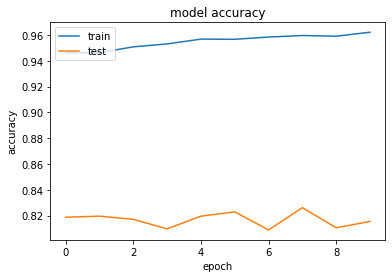

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## loss curve

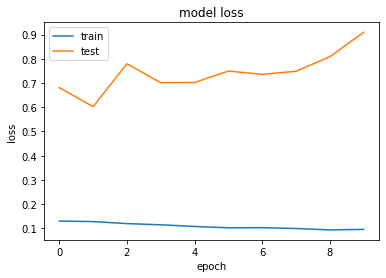

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()